# Vertical Movement Analysis at bathymetric jump

The idea is to define a metric that measure the vertical movement of a particle.
The more it moves up and down, the higher the metric.



In [1]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from oceantracker.post_processing.read_output_files import load_output_files 
from oceantracker.util.polygon_util import InsidePolygon

path_to_dir = '/scratch/local1/output/23_08_17_bath_jump_traj_v00'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)

## Hovmoeller plot of vertical movement

Lets briefly avoid the whole particle stuff and lets only look at the grid based data.
We plot x as time and y as vertical movment. 
vertical movement is estimated by $v_{advection} + \sqrt{\frac{2}{\pi}\sigma} + correction?$

Get a cleaner transect first, linspace it, find closest points in grid, get the unique set of these points, get closest node, create array of shape (n_points,n_hours_in_year), plot imshow

In [2]:
tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth','A_Z','A_Z_vertical_gradient'])

In [3]:
from netCDF4 import Dataset

df = Dataset('/scratch/local1/output/23_08_17_bath_jump_traj_v00/23_08_17_bath_jump_traj_v00_tracks.nc')

In [6]:
_ = [print(key) for key in df.variables.keys()]

dry_cell_index
particles_written_per_time_step
particle_ID
write_step_index
time
x
status
age
ID
IDrelease_group
user_release_groupID
IDpulse
time_released
x0
water_depth
water_salinity
A_Z
tide
water_velocity_depth_average
friction_velocity
A_Z_vertical_gradient
total_water_depth


In [5]:
hydro = Dataset('/scratch/local1/hzg2/schout_11.nc')

In [71]:
# close all widgets
plt.close('all')

## 2d Maps of vertical movement stuff

### depth

(5917000.0, 5939000.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
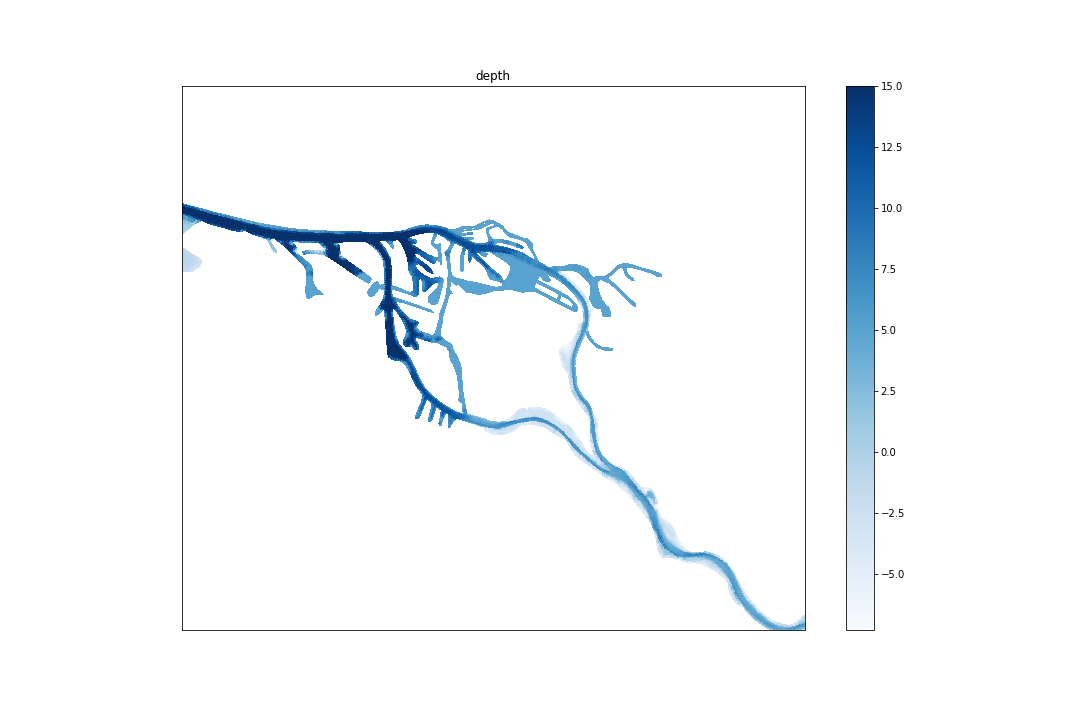

In [56]:
%matplotlib widget

grid = tracks['grid']

plt.figure(figsize=(15,10))
plt.tripcolor(grid['x'][:,0], grid['x'][:,1],  
            hydro['depth'][:],  
            triangles= grid['triangles'],cmap='Blues',
            vmax = 15, edgecolors='none', shading='flat')
plt.colorbar()

#
plt.title('depth')

# fix aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# remove x any y ticks
plt.xticks([])
plt.yticks([])

plt.xlim([5.539e5,5.791e5])
plt.ylim([5.9170e6,5.939e6])

### advection

In [61]:
hydro['vertical_velocity']

<class 'netCDF4._netCDF4.Variable'>
float32 vertical_velocity(time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers)
    missing_value: 9.96921e+36
    mesh: SCHISM_hgrid
    data_horizontal_center: node
    data_vertical_center: full
    i23d: 2
    ivs: 1
unlimited dimensions: time
current shape = (24, 32432, 21)
filling on, default _FillValue of 9.969209968386869e+36 used

In [63]:
vvel = hydro['vertical_velocity']
# create a np array from netcdf with masked values filled as nan
vvel = np.array(vvel)


# set all values greater than 1 to nan
vvel[vvel>1] = np.nan
vvel[vvel<-1] = np.nan


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
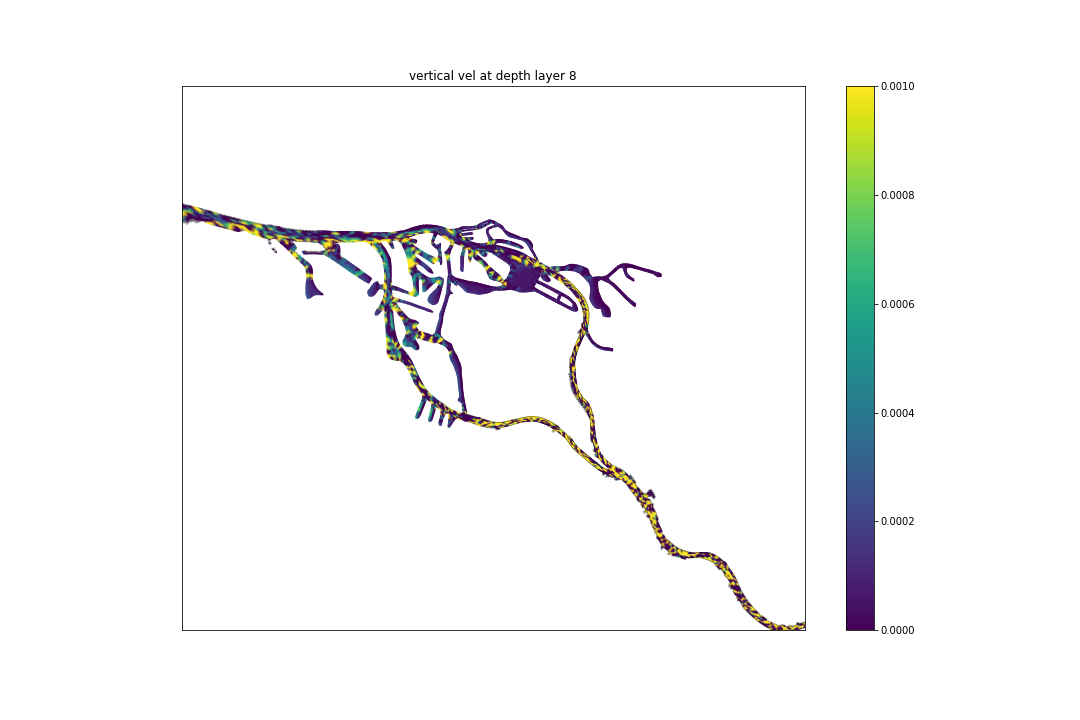

In [73]:
%matplotlib widget

grid = tracks['grid']

for ii in np.arange(8,9,4):
    plt.figure(figsize=(15,10))
    plt.tripcolor(grid['x'][:,0], grid['x'][:,1],  
                vvel[0,:,ii],  
                triangles= grid['triangles'],cmap='viridis',
                vmin=0, vmax=0.001, edgecolors='none', shading='gouraud')
    plt.colorbar()

    #
    plt.title('vertical vel at depth layer {}'.format(ii))

    # fix aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')
    # remove x any y ticks
    plt.xticks([])
    plt.yticks([])

    plt.xlim([5.539e5,5.791e5])
    plt.ylim([5.9170e6,5.939e6])

### diffusivity

In [ ]:
diff = hydro['diffusivity']
# create a np array from netcdf with masked values filled as nan
diff = np.array(diff)


# set all values greater than 1 to nan
diff[diff>1] = np.nan


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
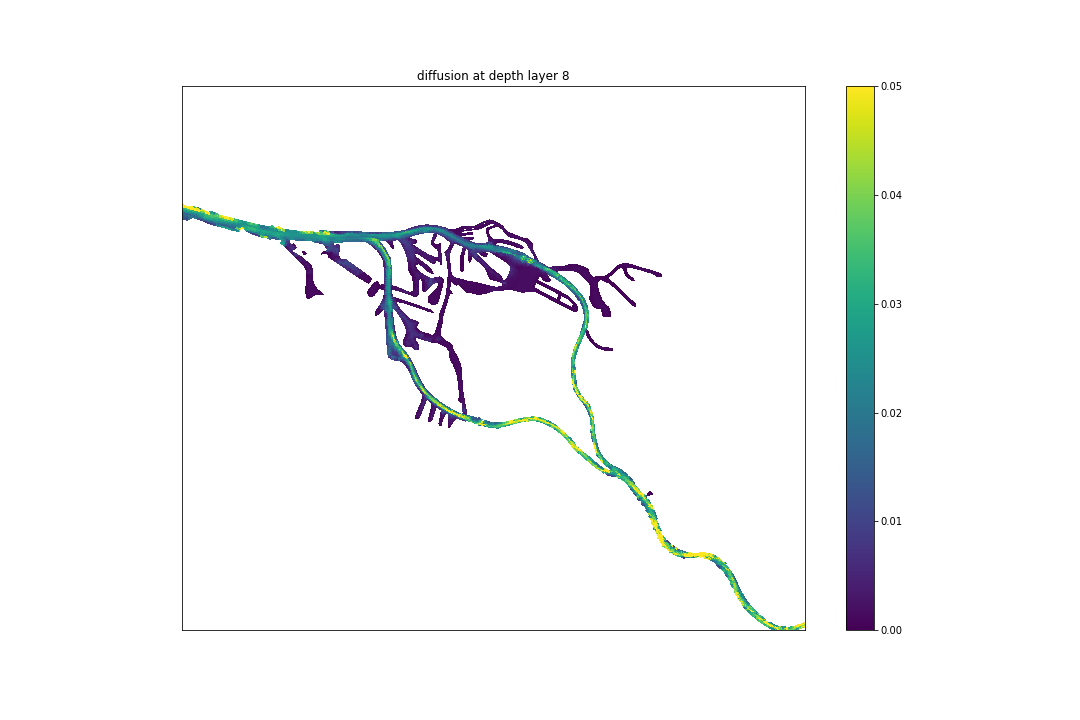

In [74]:
%matplotlib widget

grid = tracks['grid']

for ii in np.arange(8,9,4):
    plt.figure(figsize=(15,10))
    plt.tripcolor(grid['x'][:,0], grid['x'][:,1],  
                diff[0,:,ii],  
                triangles= grid['triangles'],cmap='viridis',
                vmin=0, vmax=0.05, edgecolors='none', shading='flat')
    plt.colorbar()

    #
    plt.title('diffusion at depth layer {}'.format(ii))

    # fix aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')
    # remove x any y ticks
    plt.xticks([])
    plt.yticks([])

    plt.xlim([5.539e5,5.791e5])
    plt.ylim([5.9170e6,5.939e6])

### advection + diffusivity + correction

In [83]:
# -- advection --
vvel = hydro['vertical_velocity']
# create a np array from netcdf with masked values filled as nan
vvel = np.array(vvel)


# set all values greater than 1 to nan
vvel[vvel>1] = np.nan
vvel[vvel<-1] = np.nan

avg_vvel = np.nanmean(vvel, axis=2)
avg_vvel = np.nanmean(avg_vvel, axis=0)
# take absolute value
avg_vvel = np.abs(avg_vvel)

# -- dispersion --
diff = hydro['diffusivity']
# create a np array from netcdf with masked values filled as nan
diff = np.array(diff)


# set all values greater than 1 to nan
diff[diff>1] = np.nan


# -- averages --
avg_diff = np.nanmean(diff, axis=2)
avg_diff = np.nanmean(avg_diff, axis=0)
avg_diff = np.sqrt(2/np.pi * avg_diff)

total_vertical = np.abs(vvel) + np.sqrt(2/np.pi * diff)

# average over depth (axis 2) where entries with nan are ignored 
avg_total_vertical = np.nanmean(total_vertical, axis=2)
avg_total_vertical = np.nanmean(avg_total_vertical, axis=0)

avg_total_vertical = avg_vvel + avg_diff

depth = hydro['depth']
depth = np.array(depth)
# greater or smaller 30m set to nan
depth[depth>30] = np.nan
depth[depth<-30] = np.nan


norm_avg_total_vertical = avg_total_vertical/depth

/tmp/ipykernel_8192/2380308084.py:46: RuntimeWarning: divide by zero encountered in true_divide
  norm_avg_total_vertical = avg_total_vertical/depth


In [82]:
hydro['depth'][:]

masked_array(data=[ 2.  ,  5.  ,  5.  , ...,  2.99, -3.84, -4.16],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

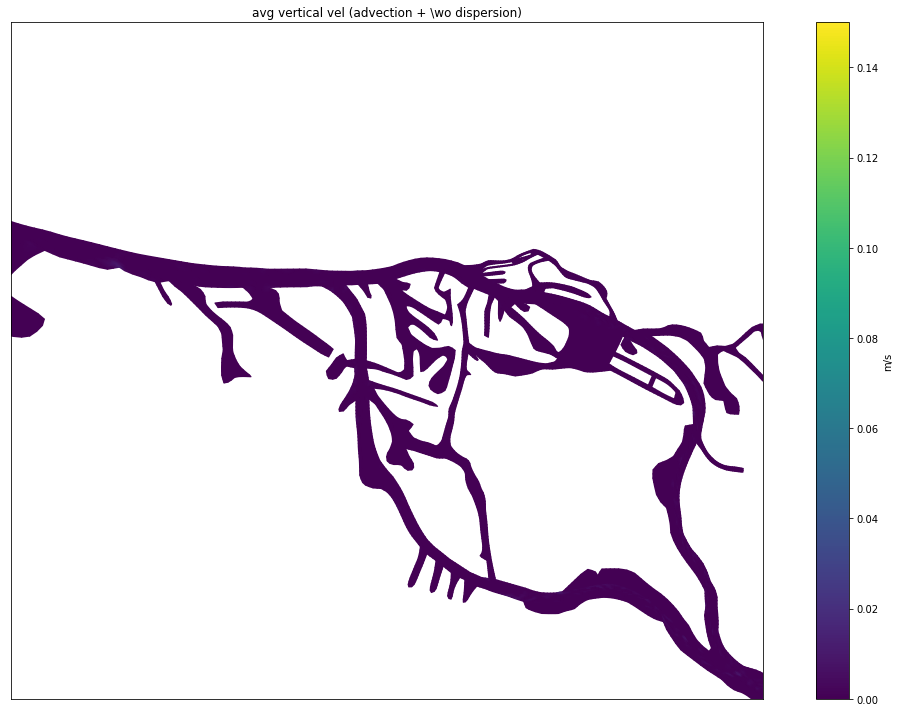

In [60]:
%matplotlib inline

grid = tracks['grid']

fig, ax = plt.subplots(figsize=(15,10))
ax.tripcolor(grid['x'][:,0], grid['x'][:,1],  
            avg_vvel[:],  
            triangles= grid['triangles'],cmap='viridis',
            vmin=0, vmax=0.15, edgecolors='none', shading='gouraud')

# add colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax)
# colorbar title
cbar.ax.set_ylabel('m/s')

#
plt.title('avg vertical vel (advection + \wo dispersion)')

# fix aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# remove x any y ticks
plt.xticks([])
plt.yticks([])

plt.xlim([5.539e5,5.718e5])
plt.ylim([5.9229e6,5.939e6])
plt.tight_layout()
plt.savefig('adv.png', dpi=300)

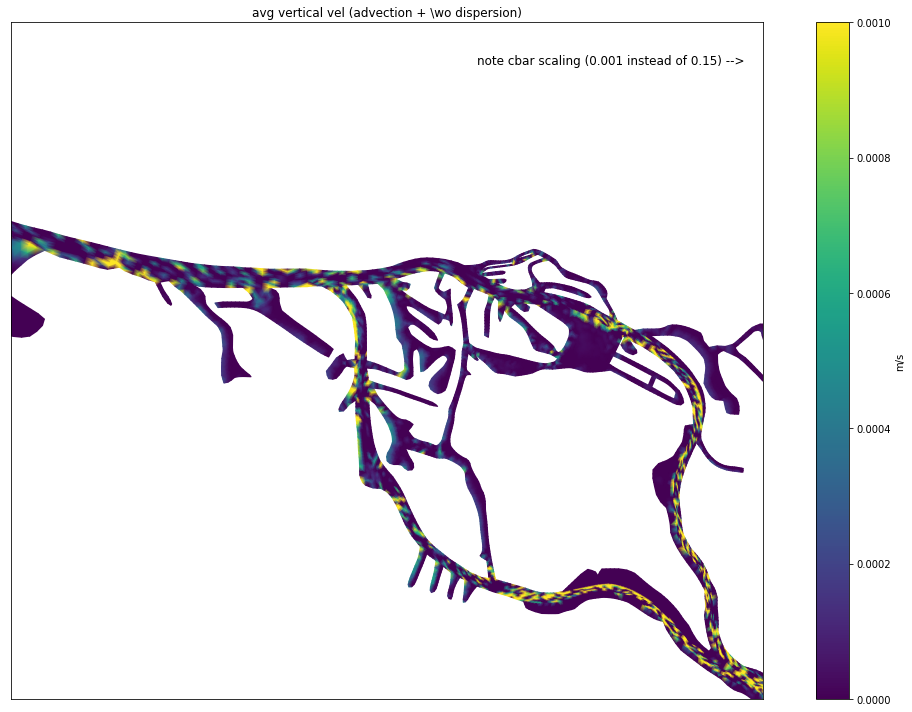

In [61]:
%matplotlib inline

grid = tracks['grid']

fig, ax = plt.subplots(figsize=(15,10))
ax.tripcolor(grid['x'][:,0], grid['x'][:,1],  
            avg_vvel[:],  
            triangles= grid['triangles'],cmap='viridis',
            vmin=0, vmax=0.001, edgecolors='none', shading='gouraud')

# add colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax)
# colorbar title
cbar.ax.set_ylabel('m/s')

#
plt.title('avg vertical vel (advection + \wo dispersion)')

# fix aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# remove x any y ticks
plt.xticks([])
plt.yticks([])

# add at top right hinting at cbar
plt.text(5.65e5, 5.938e6, 'note cbar scaling (0.001 instead of 0.15) -->', fontsize=12)

plt.xlim([5.539e5,5.718e5])
plt.ylim([5.9229e6,5.939e6])
plt.tight_layout()
plt.savefig('adv_scaled.png', dpi=300)

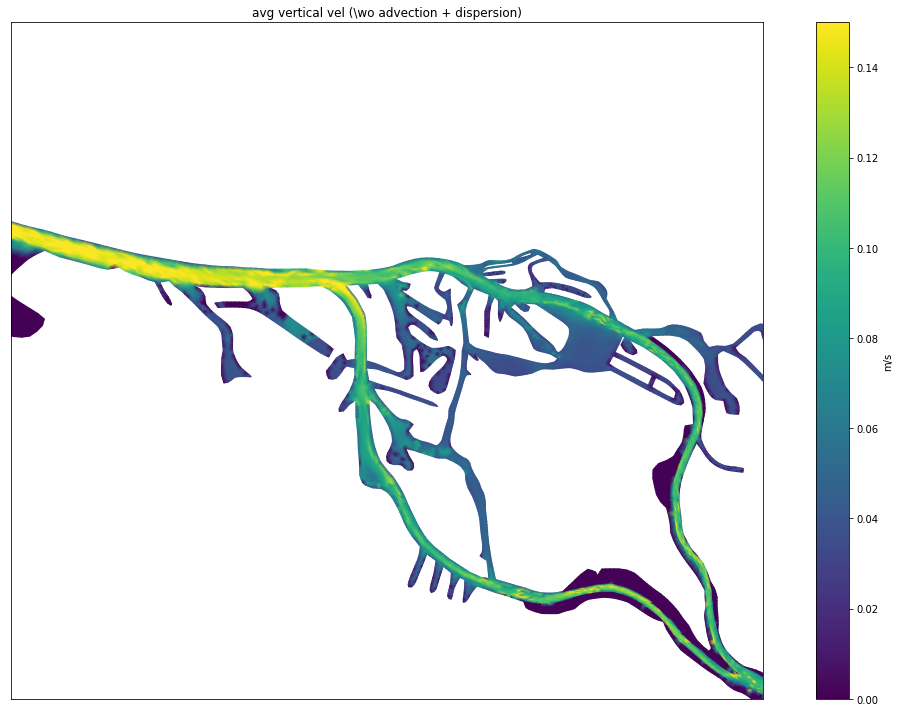

In [95]:
%matplotlib inline

grid = tracks['grid']

fig, ax = plt.subplots(figsize=(15,10))
ax.tripcolor(grid['x'][:,0], grid['x'][:,1],  
            avg_diff[:],  
            triangles= grid['triangles'],cmap='viridis',
            vmin=0, vmax=0.15, edgecolors='none', shading='gouraud')

# add colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax)
# colorbar title
cbar.ax.set_ylabel('m/s')

#
plt.title('avg vertical vel (\wo advection + dispersion)')

# fix aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# remove x any y ticks
plt.xticks([])
plt.yticks([])

plt.xlim([5.539e5,5.718e5])
plt.ylim([5.9229e6,5.939e6])
plt.tight_layout()
plt.savefig('dis.png', dpi=300)

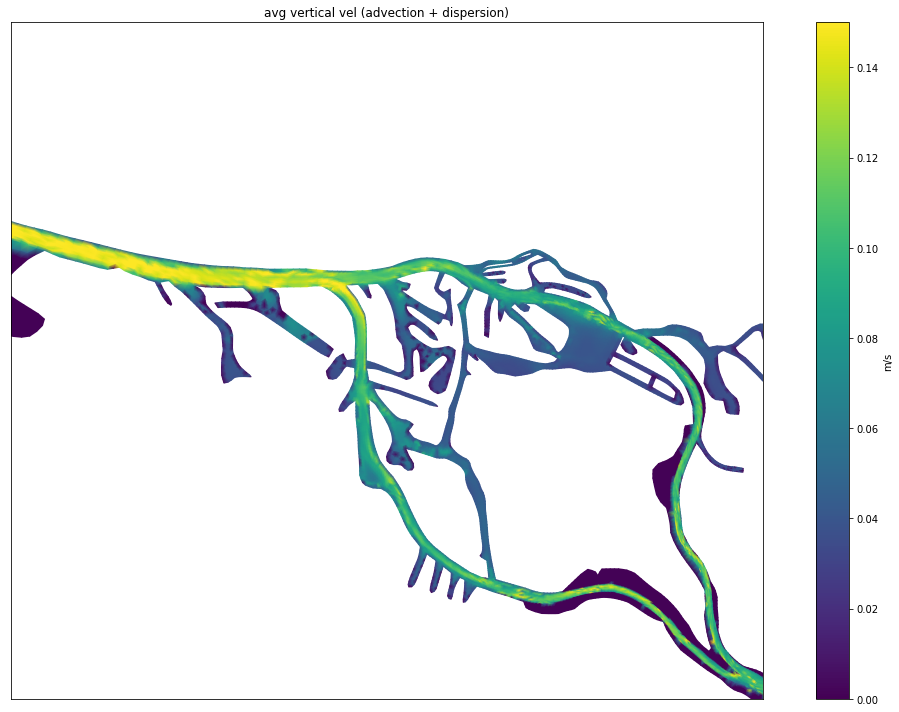

In [63]:
%matplotlib inline

grid = tracks['grid']

fig, ax = plt.subplots(figsize=(15,10))
ax.tripcolor(grid['x'][:,0], grid['x'][:,1],  
            avg_total_vertical[:],  
            triangles= grid['triangles'],cmap='viridis',
            vmin=0, vmax=0.15, edgecolors='none', shading='gouraud')

# add colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax)
# colorbar title
cbar.ax.set_ylabel('m/s')

#
plt.title('avg vertical vel (advection + dispersion)')

# fix aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# remove x any y ticks
plt.xticks([])
plt.yticks([])

plt.xlim([5.539e5,5.718e5])
plt.ylim([5.9229e6,5.939e6])
plt.tight_layout()
plt.savefig('adv_dis.png', dpi=300)

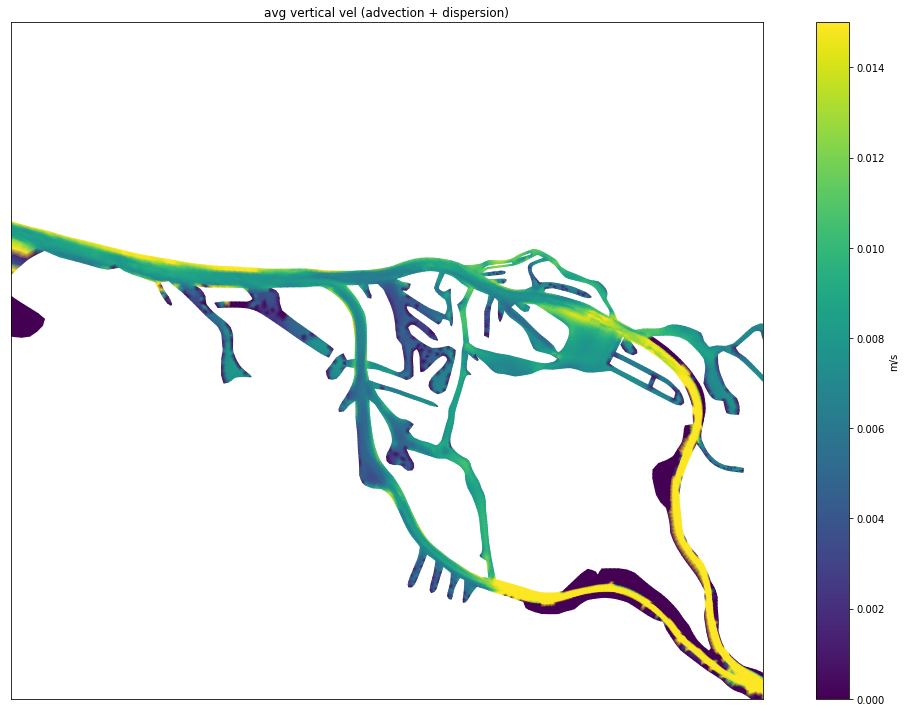

In [94]:
%matplotlib inline

grid = tracks['grid']

fig, ax = plt.subplots(figsize=(15,10))
ax.tripcolor(grid['x'][:,0], grid['x'][:,1],  
            norm_avg_total_vertical[:],  
            triangles= grid['triangles'],cmap='viridis',
            vmin=0, vmax=0.015, edgecolors='none', shading='gouraud')

# add colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax)
# colorbar title
cbar.ax.set_ylabel('m/s')

#
plt.title('normalized by depth avg vertical vel (advection + dispersion)')

# fix aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# remove x any y ticks
plt.xticks([])
plt.yticks([])

plt.xlim([5.539e5,5.718e5])
plt.ylim([5.9229e6,5.939e6])
plt.tight_layout()
plt.savefig('norm_adv_dis.png', dpi=300)

## Hovmoller plots

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
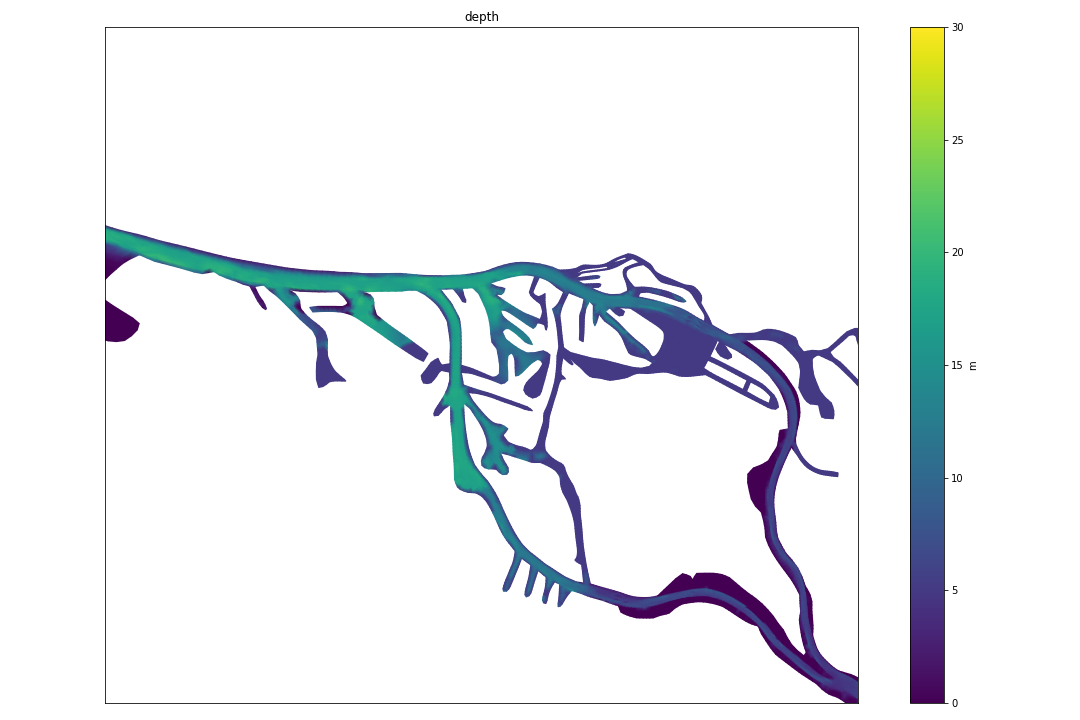

x = 566058.3647638971, y = 5925354.654787952
x = 554923.4142512813, y = 5934375.79612444
x = 570194.6431158485, y = 5930139.075178479
x = 570194.6431158485, y = 5930139.075178479
x = 570194.6431158485, y = 5930139.075178479
x = 570194.6431158485, y = 5930139.075178479
x = 570194.6431158485, y = 5930139.075178479
x = 570154.6927783435, y = 5930248.938606617
x = 570114.7424408384, y = 5930338.826866004
x = 570024.854181452, y = 5930488.640631648
x = 569944.9535064418, y = 5930608.491644163
x = 569835.0900783029, y = 5930738.330241054
x = 569695.263897035, y = 5930858.18125357
x = 569605.3756376486, y = 5930968.044681708
x = 569425.5991188758, y = 5931097.8832786
x = 569215.8598469741, y = 5931247.697044244
x = 569046.0709125776, y = 5931367.54805676
x = 568826.3440562997, y = 5931507.374238027
x = 568596.6296156455, y = 5931627.225250542
x = 568436.8282656252, y = 5931697.138341176
x = 568177.1510718422, y = 5931826.976938068
x = 567937.4490468117, y = 5931936.840366207
x = 567717.722190

In [101]:
#make a clickable map to get xy coordinates for high res transect

%matplotlib widget

grid = tracks['grid']

fig, ax = plt.subplots(figsize=(15,10))
ax.tripcolor(grid['x'][:,0], grid['x'][:,1],
            depth[:],
            triangles= grid['triangles'],cmap='viridis',
            vmin=0, vmax=30, edgecolors='none', shading='gouraud')

# add colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax)

# colorbar title
cbar.ax.set_ylabel('m')

#
plt.title('depth')

# fix aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# remove x any y ticks
plt.xticks([])
plt.yticks([])
plt.xlim([5.539e5,5.718e5])
plt.ylim([5.9229e6,5.939e6])

# print xy coordinates when clicked and write it to file
def onclick(event):

    # get xy coordinates
    x = event.xdata
    y = event.ydata
    
    # write to file
    with open('xy_coords.txt', 'a') as f:
        f.write('{},{}\n'.format(x,y))
    
    # print to console
    print('x = {}, y = {}'.format(x,y))

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.tight_layout()

In [107]:
points = """570194.6431158485,5930139.075178479
570154.6927783435,5930248.938606617
570114.7424408384,5930338.826866004
570024.854181452,5930488.640631648
569944.9535064418,5930608.491644163
569835.0900783029,5930738.330241054
569695.263897035,5930858.18125357
569605.3756376486,5930968.044681708
569425.5991188758,5931097.8832786
569215.8598469741,5931247.697044244
569046.0709125776,5931367.54805676
568826.3440562997,5931507.374238027
568596.6296156455,5931627.225250542
568436.8282656252,5931697.138341176
568177.1510718422,5931826.976938068
567937.4490468117,5931936.840366207
567717.7221905338,5932066.678963099
567398.1194904932,5932206.505144366
567058.5416217,5932346.331325634
566728.9513372831,5932416.244416268
566519.2120653815,5932446.207169397
566289.4976247273,5932446.207169397
566049.7955996968,5932476.169922525
565889.9942496766,5932476.169922525
565720.20531528,5932496.145091278
565530.4412121308,5932566.058181912
565230.8136808428,5932705.88436318
564991.1116558124,5932805.760206942
564691.4841245243,5932985.536725715
564371.8814244836,5933135.350491359
563942.415296304,5933225.238750746
563652.7753493923,5933205.263581993
563363.1354024805,5933135.350491359
563023.5575336873,5933065.437400726
562803.8306774094,5932975.549141339
562384.3521336061,5932955.573972587
562064.7494335654,5932925.611219457
561705.1963960198,5932925.611219457
561365.6185272266,5932905.636050705
560986.0903209284,5932945.58638821
560496.6986864912,5932885.660881952
560077.2201426879,5932865.6857132
559667.7291832609,5932895.648466329
559168.3499644474,5932915.623635082
558589.0700706238,5932925.611219457
558079.7032674341,5932945.58638821
557750.1129830172,5933005.511894467
557260.72134858,5933065.437400726
556871.2055579055,5933215.25116637
556531.6276891123,5933325.114594508
556002.2857171701,5933395.027685142
555432.9934077228,5933564.816619539
554993.539695167,5933664.692463301
"""

# create a array shape (n,2) with xy coordinates form points
points = np.array([point.split(',') for point in points.split('\n')[:-1]]).astype(float)
points[-1]


array([ 554993.53969517, 5933664.6924633 ])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
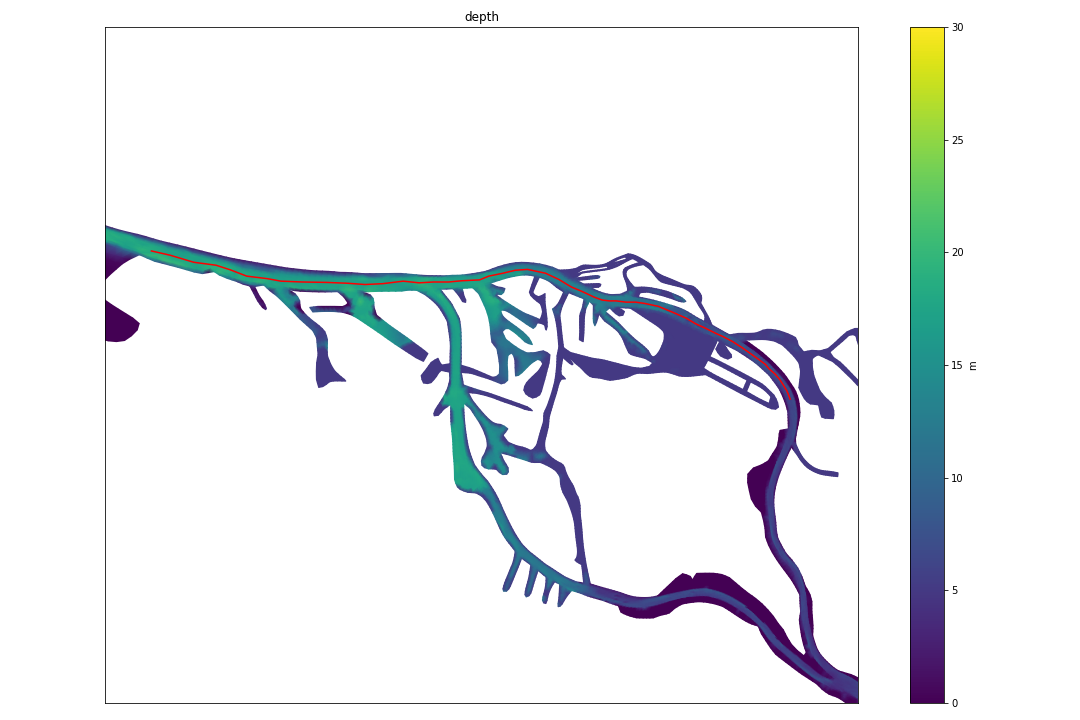

In [177]:

#make a clickable map to get xy coordinates for high res transect

%matplotlib widget

grid = tracks['grid']

fig, ax = plt.subplots(figsize=(15,10))
ax.tripcolor(grid['x'][:,0], grid['x'][:,1],
            depth[:],
            triangles= grid['triangles'],cmap='viridis',
            vmin=0, vmax=30, edgecolors='none', shading='gouraud')

# plot points on map
ax.plot(points[:,0], points[:,1], 'r')

# add colorbar
cbar = fig.colorbar(ax.collections[0], ax=ax)

# colorbar title
cbar.ax.set_ylabel('m')

#
plt.title('depth')

# fix aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# remove x any y ticks
plt.xticks([])
plt.yticks([])
plt.xlim([5.539e5,5.718e5])
plt.ylim([5.9229e6,5.939e6])

plt.tight_layout()
plt.savefig('transect.png', dpi=300)

In [129]:
def calc_avg_total_vertical_vel(hydro):
    # -- advection --
    vvel = hydro['vertical_velocity']
    # create a np array from netcdf with masked values filled as nan
    vvel = np.array(vvel)


    # set all values greater than 1 to nan
    vvel[vvel>1] = np.nan
    vvel[vvel<-1] = np.nan

    avg_vvel = np.nanmean(vvel, axis=2)
    avg_vvel = np.nanmean(avg_vvel, axis=0)
    # take absolute value
    avg_vvel = np.abs(avg_vvel)

    # -- dispersion --
    diff = hydro['diffusivity']
    # create a np array from netcdf with masked values filled as nan
    diff = np.array(diff)


    # set all values greater than 1 to nan
    diff[diff>1] = np.nan

    # -- averages --
    avg_diff = np.nanmean(diff, axis=2)
    avg_diff = np.nanmean(avg_diff, axis=0)
    avg_diff = np.sqrt(2/np.pi * avg_diff)

    # total_vertical = np.abs(vvel) + np.sqrt(2/np.pi * diff)

    # average over depth (axis 2) where entries with nan are ignored 
    # avg_total_vertical = np.nanmean(total_vertical, axis=2)
    # avg_total_vertical = np.nanmean(avg_total_vertical, axis=0)

    avg_total_vertical = avg_vvel + avg_diff

    return avg_total_vertical

In [124]:
# get files in folder
files = os.listdir('/scratch/local1/hzg2/')
# filter for files with schout_*.nc 
files = [file for file in files if 'schout_' in file]
files = [file for file in files if '.nc' in file]
# sort such that ['schout_1.nc','schout_2,.nc',...,'schout_10.nc',...]
files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
# files

# load grid
tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth','A_Z','A_Z_vertical_gradient'])
grid = tracks['grid']


In [130]:
# create emtpy array to store avg_total_vertical_vel
avg_total_vertical_vel = np.zeros((len(files), len(grid['x'])))

for ii, item in enumerate(files):
    print(ii, item)

    # load hydro files
    hydro = Dataset('/scratch/local1/hzg2/{}'.format(item))

    # calculate avg_total_vertical_vel
    avg_total_vertical_vel[ii,:] = calc_avg_total_vertical_vel(hydro)


0 schout_1.nc
1 schout_2.nc
2 schout_3.nc
3 schout_4.nc
4 schout_5.nc
5 schout_6.nc
6 schout_7.nc
7 schout_8.nc
8 schout_9.nc
9 schout_10.nc
10 schout_11.nc
11 schout_12.nc
12 schout_13.nc
13 schout_14.nc
14 schout_15.nc
15 schout_16.nc
16 schout_17.nc
17 schout_18.nc
18 schout_19.nc
19 schout_20.nc
20 schout_21.nc
21 schout_22.nc
22 schout_23.nc
23 schout_24.nc
24 schout_25.nc
25 schout_26.nc
26 schout_27.nc
27 schout_28.nc
28 schout_29.nc
29 schout_30.nc
30 schout_31.nc
31 schout_32.nc
32 schout_33.nc
33 schout_34.nc
34 schout_35.nc
35 schout_36.nc
36 schout_37.nc
37 schout_38.nc
38 schout_39.nc
39 schout_40.nc
40 schout_41.nc
41 schout_42.nc
42 schout_43.nc
43 schout_44.nc
44 schout_45.nc
45 schout_46.nc
46 schout_47.nc
47 schout_48.nc
48 schout_49.nc
49 schout_50.nc
50 schout_51.nc
51 schout_52.nc
52 schout_53.nc
53 schout_54.nc
54 schout_55.nc
55 schout_56.nc
56 schout_57.nc
57 schout_58.nc
58 schout_59.nc
59 schout_60.nc
60 schout_61.nc
61 schout_62.nc
62 schout_63.nc
63 schout_6

In [141]:
# get data interpolated at points
# the grid is in an triangulation
# so we can use the function interpolate from matplotlib.tri
from matplotlib.tri import Triangulation, LinearTriInterpolator

# create a triangulation object
tri = Triangulation(grid['x'][:,0], grid['x'][:,1], triangles=grid['triangles'])

# create a linear interpolator object
avg_total_vertical_interpolator = LinearTriInterpolator(tri, avg_total_vertical[:])

# interpolate at points
# avg_total_vertical_at_points = avg_total_vertical_interpolator(points[:,0], points[:,1])


In [144]:
# get data interpolated at points
# the grid is in an triangulation
# so we can use the function interpolate from matplotlib.tri
from matplotlib.tri import Triangulation, LinearTriInterpolator

# create a triangulation object
tri = Triangulation(grid['x'][:,0], grid['x'][:,1], triangles=grid['triangles'])

avg_total_vertical_vel_interpolated = np.zeros((len(files), len(points)))

for ii, item in enumerate(avg_total_vertical_vel):
    # create a linear interpolator object
    avg_total_vertical_interpolator = LinearTriInterpolator(tri, avg_total_vertical_vel[ii])
    # interpolate avg_total_vertical_vel to points
    avg_total_vertical_vel_interpolated[ii,:] = avg_total_vertical_interpolator(points[:,0], points[:,1])

avg_total_vertical_vel_interpolated

(366, 53)

In [191]:
# commulative sum the distance between the points
# this is the distance along the transect
dist = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
dist = np.append([0],dist)

/tmp/ipykernel_8192/3122878933.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(np.append([0],dist)).astype(int))


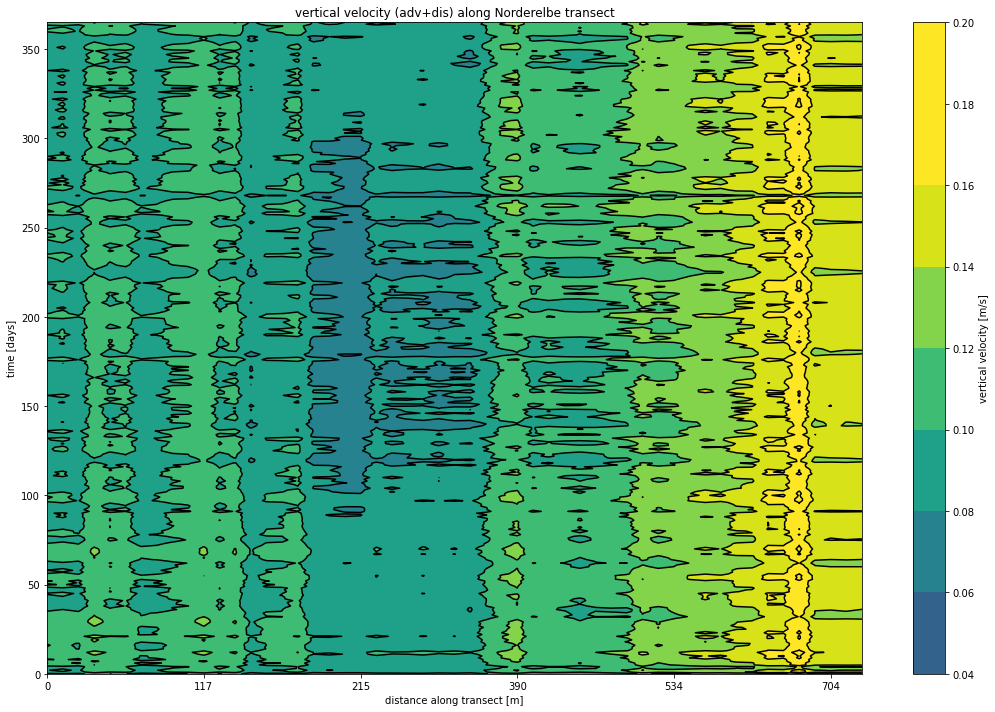

In [190]:
# make a contour plot contourf of avg_total_vertical_vel
%matplotlib inline

vmax = 0.16

fig, ax = plt.subplots(figsize=(15,10))

# create meshgrid based on shape of avg_total_total_vel such that it is roughly square
X,Y = np.meshgrid(np.arange(avg_total_vertical_vel_interpolated.shape[1]), np.arange(avg_total_vertical_vel_interpolated.shape[0]))

# plot contourf
ax.contourf(X,Y,avg_total_vertical_vel_interpolated, cmap='viridis', vmin=0, vmax=vmax)
ax.contour(X,Y,avg_total_vertical_vel_interpolated, colors='k', vmin=0, vmax=vmax)

# add colorbar
#cbar = fig.colorbar(ax.collections[0],ax=ax)
# previous coloar bar is not working. does not show the correct limits
# so we create a new one
cbar = fig.colorbar(ax.contourf(X,Y,avg_total_vertical_vel_interpolated, cmap='viridis', vmin=0, vmax=vmax), ax=ax)
# make colorbar range from 0 to vmax


# colorbar title
cbar.ax.set_ylabel('vertical velocity [m/s]')

# set x labels based on dist and don't show decimals
ax.set_xticklabels(np.round(dist).astype(int))

# set labels
ax.set_xlabel('distance along transect [m]')
ax.set_ylabel('time [days]')

# set title
ax.set_title('vertical velocity (adv+dis) along Norderelbe transect')

# save
plt.tight_layout()
plt.savefig('vertical_velocity_along_transect.png', dpi=300)

In [197]:
depth_interpolator = LinearTriInterpolator(tri, depth[:])

# interpolate at points
depth_interpolated = depth_interpolator(points[:,0], points[:,1])

depth_interpolated

masked_array(data=[6.062411070935923, 6.258801857147773,
                   6.038310989708407, 7.210002586667542,
                   7.188989918009611, 7.604497614607681,
                   7.067732111318037, 7.027188998748898,
                   7.210445196309593, 7.438586482749088,
                   7.8989010646619136, 8.03534148602921,
                   9.343831372782006, 7.868687633410445,
                   7.584799330899841, 7.573261886180262,
                   8.916150582052069, 8.418701443297323,
                   11.304227092739893, 11.055334354459774,
                   11.439287297798728, 12.263500361999832,
                   12.181969444272909, 12.226666806460315,
                   12.539610682739294, 12.339211486760178,
                   12.786061938704734, 12.468927055997483,
                   13.155143716621751, 13.723973940600445,
                   13.355955650746182, 13.568100183627394,
                   15.750051241417395, 17.041416459556785,
               

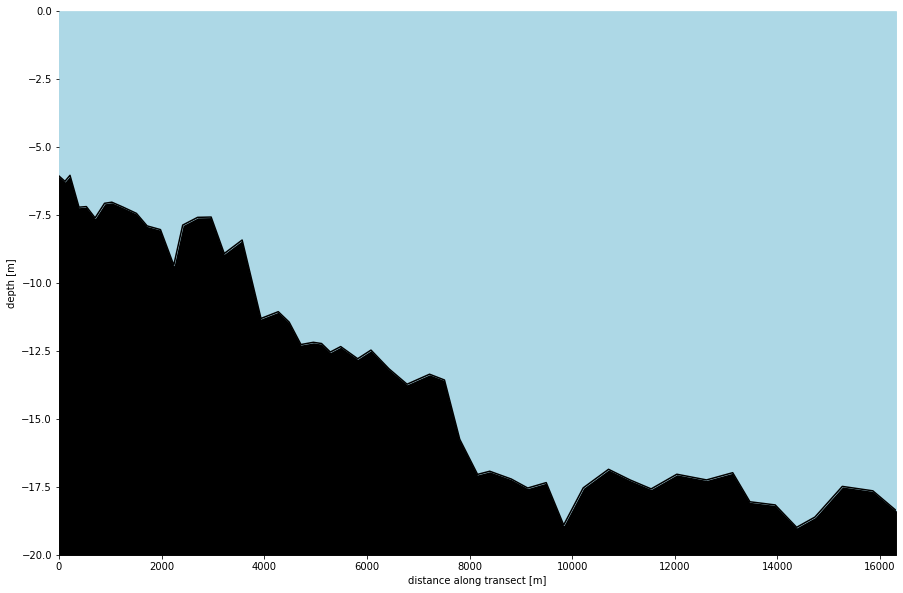

In [224]:

# plot depth along transect

%matplotlib inline

fig, ax = plt.subplots(figsize=(15,10))

# plot depth
ax.plot(dist, -depth_interpolated, 'k')

# make area between -20 and -depth_interpolated black
ax.fill_between(dist, -depth_interpolated, -20, color='black')
# make area between -depth_interpolated and 0 light blue
ax.fill_between(dist, -depth_interpolated, 0, color='lightblue')

ax.set_xlim([0, 1*dist[-1]])
ax.set_ylim([-20, 0])

ax.set_xlabel('distance along transect [m]')
ax.set_ylabel('depth [m]')

# remove spine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('depth_along_transect.png', dpi=300)


In [221]:
box

Bbox([[0.125, 0.7427272727272727], [0.9, 0.88]])

/tmp/ipykernel_8192/3775085533.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.round(dist).astype(int))


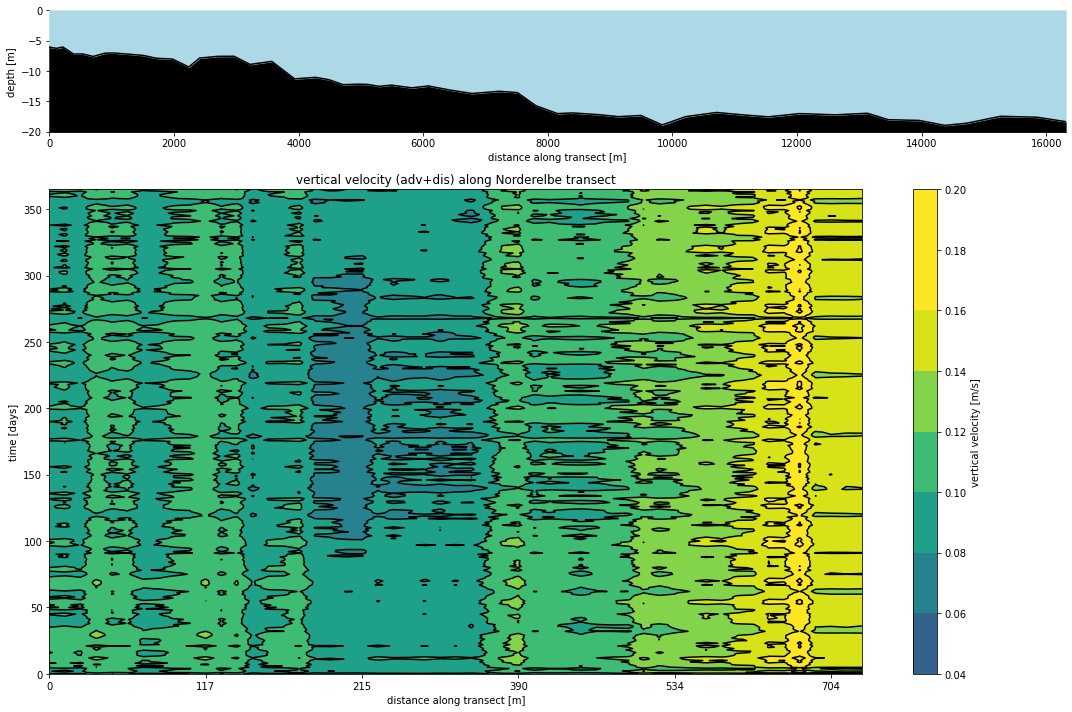

In [223]:
# combine the last two plonts into one


# fig,ax = plt.subplots(2,1, figsize=(15,10))
# make vertial ratio 1:4
fig,ax = plt.subplots(2,1, figsize=(15,10), gridspec_kw={'height_ratios': [1, 4]})

# plot depth
ax[0].plot(dist, -depth_interpolated, 'k')

# make area between -20 and -depth_interpolated black
ax[0].fill_between(dist, -depth_interpolated, -20, color='black')
# make area between -depth_interpolated and 0 light blue
ax[0].fill_between(dist, -depth_interpolated, 0, color='lightblue')

ax[0].set_xlim([0, 1*dist[-1]])
ax[0].set_ylim([-20, 0])

ax[0].set_xlabel('distance along transect [m]')
ax[0].set_ylabel('depth [m]')

# remove spine
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)

# make the frame of ax[0] shorter on the horizontal axis
# such that the two plots are aligned



# make hovmueller plot
# create meshgrid based on shape of avg_total_total_vel such that it is roughly square
X,Y = np.meshgrid(np.arange(avg_total_vertical_vel_interpolated.shape[1]), np.arange(avg_total_vertical_vel_interpolated.shape[0]))

# plot contourf
ax[1].contourf(X,Y,avg_total_vertical_vel_interpolated, cmap='viridis', vmin=0, vmax=vmax)
ax[1].contour(X,Y,avg_total_vertical_vel_interpolated, colors='k', vmin=0, vmax=vmax)

# add colorbar
#cbar = fig.colorbar(ax.collections[0],ax=ax)
# previous coloar bar is not working. does not show the correct limits
# so we create a new one
cbar = fig.colorbar(ax[1].contourf(X,Y,avg_total_vertical_vel_interpolated, cmap='viridis', vmin=0, vmax=vmax), ax=ax[1])
# make colorbar range from 0 to vmax


# colorbar title
cbar.ax.set_ylabel('vertical velocity [m/s]')

# set x labels based on dist and don't show decimals
ax[1].set_xticklabels(np.round(dist).astype(int))

# set labels
ax[1].set_xlabel('distance along transect [m]')
ax[1].set_ylabel('time [days]')

# set title
ax[1].set_title('vertical velocity (adv+dis) along Norderelbe transect')

# save
plt.tight_layout()
# plt.savefig('vertical_velocity_along_transect.png', dpi=300)



In [195]:
depth_interpolated

masked_array(data=[0.10673148156877232, 0.10924403804870053,
                   0.10596219841409038, 0.12098222337749576,
                   0.11134106025656365, 0.11327156145580375,
                   0.10162524938778006, 0.10501720367710732,
                   0.10961079598382639, 0.11168038241930844,
                   0.11984721025467593, 0.11023233301125401,
                   0.1213558853186214, 0.09695284680265104,
                   0.10658824582480975, 0.10680136822497843,
                   0.11639095015925705, 0.09818102376084425,
                   0.10449302665529103, 0.09988162859553995,
                   0.09860534038932656, 0.0995576929976778,
                   0.0970145527215891, 0.09548245148857859,
                   0.09757281428653641, 0.09331060495333077,
                   0.09558583427849499, 0.09030885862962634,
                   0.1023439703681106, 0.11786982578212246,
                   0.1259395848103395, 0.11281382484628466,
                   0.11706309

## FFT stuff

This metric could be expressed as a particle propertie that is carried at each time step based on the recent time steps (the amout of time steps could also be zero - only checking the current vertical velocity)

The particle property could then be averaged over a cell plotted as a horizontal tripcolor plot.
If the concentration of particles is high enough, we might also be able to slice triangles further down into maybe a hexbin plot.

What if we looked at the fft?

It is messy to work with a bunch of time series with different length.
I can't think of a better approach than to slice the trajectories into section of ~a day in length?

In [2]:
tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

In [5]:
_ = [print(key) for key in tracks.keys()]
    

dimensions
total_num_particles_released
status
dry_cell_index
x
IDrelease_group
water_depth
tide
x0
IDpulse
time
z
grid
particle_status_flags
particle_release_group_info
full_params
axis_lim


In [17]:
# time step between observations in s
dt = tracks['time'][1] - tracks['time'][0]
# number of time steps in a day
slice_lenght = 86400
nsteps_slice = int(slice_lenght/dt)

# take each particles trajectory, crop it to the "alive" region in time,
# and slice this into daylong chunks discarding the tail at the end that
# is shorter than a day

trajectories = []
for ii in range(tracks['x'].shape[1]):

    # get the z coordinate of the particle and slive for "alive"
    z = tracks['x'][:,ii,2]
    alive = np.where(tracks['status'][:,ii] > 0)

    # find the first time the particle is in the "alive" region
    # and slice the trajectory
    idx_first_alive = np.where(tracks['status'][:,ii] > 0)[0][0]
    idx_last_alive = np.where(tracks['status'][:,ii] > 0)[0][-1]

    first_alive = tracks['time'][idx_first_alive]
    last_alive = tracks['time'][idx_last_alive]


    # number of days alive
    nslices = int((last_alive - first_alive)/slice_lenght)
    for jj in range(nslices):
        # slice the trajectory
        trajectories.append(
            z[idx_first_alive + jj*nsteps_slice : idx_first_alive + (jj+1)*nsteps_slice]
            )
        # print(str(jj).zfill(2),
        #       datetime.fromtimestamp((tracks['time'][idx_first_alive + jj*nsteps_slice])),
        #       datetime.fromtimestamp((tracks['time'][idx_first_alive + (jj+1)*nsteps_slice]))
        #       )
        
    

    if ii > 2:
        break

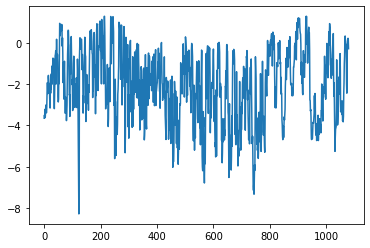

In [20]:
plt.plot(trajectories[0])

(1.0, 100.0)

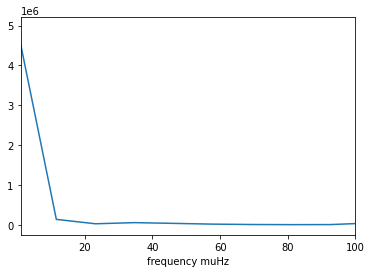

In [31]:
# do an fft for the first trajectory
# and plot the power spectrum for the real frequencies

ii = 0
dt = tracks['time'][1] - tracks['time'][0]
n_steps = len(trajectories[ii])

# get the frequencies
fft_freqs = np.fft.rfftfreq(n_steps, dt)
fft_output = np.fft.rfft(trajectories[ii])

powerspectrum = np.abs(fft_output)**2

# plot the real part of the power spectrum
plt.plot(fft_freqs*1e6, powerspectrum.real)
plt.xlabel('frequency muHz')
plt.xlim(1, 100)



In [40]:
# day in sec
1/86400

1.1574074074074073e-05

In [42]:
1/9.64506173e-07 > 1/86400

True

In [49]:
import numpy as np
from scipy.signal import find_peaks

def fourier_analysis(tracks, delta_t, particle_indices):
    result = {}
    frequency_range = [1 / 1.1*86400, 1 / 0.9*86400]  # frequency range in Hz

    for ii in particle_indices:
        # Get the vertical movement data
        data = tracks['x'][:, ii, 2][tracks['status'][:, ii] > 0]

        if len(data) == 0:
            continue

        # Calculate the FFT of the data
        n = len(data)
        fft_output = np.fft.fft(data)
        fft_freqs = np.fft.fftfreq(n, delta_t)
        # print(fft_freqs)

        # Find the indices of the frequency range of interest
        indices = np.where((fft_freqs >= frequency_range[0]) & (fft_freqs <= frequency_range[1]))[0]

        # Calculate the power spectrum (you might be interested in the amplitude which is np.abs(fft_output))
        power_spectrum = np.abs(fft_output)**2

        # You might want to find peaks in the power spectrum to identify dominant frequencies in the range
        peaks, _ = find_peaks(power_spectrum)

        result[ii] = {
            'frequencies': fft_freqs,
            'power_spectrum': power_spectrum,
            'indices': indices,
            'peaks': peaks
        }

    return result

/tmp/ipykernel_4105/3656301980.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/results[ii]['frequencies']/86400, results[ii]['power_spectrum'])


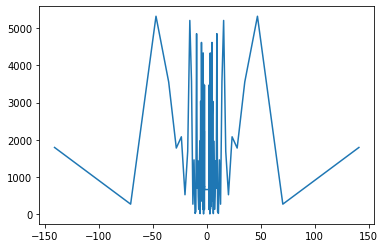

In [60]:
results = fourier_analysis(tracks,(tracks['time'][1] - tracks['time'][0]), range(3)) #range(tracks['x'].shape[1]))

ii = 2
plt.plot(1/results[ii]['frequencies']/86400, results[ii]['power_spectrum'])